# 7 Data Transformation

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
df = pd.read_csv('train.csv')

In [31]:
#dealing with missing data
sufficientcolumns = df.isnull().sum() < 2
df = df.loc[:, sufficientcolumns] # keep only columns that have less than 2 missing values
df = df.drop(df.loc[df['Electrical'].isnull()].index) # remove the sample that has a missing value for Electrical

In [32]:
#deleting outliers
df.sort_values(by = 'GrLivArea', ascending = False)[:2]
df = df.drop(df[df.Id == 1299].index)
df = df.drop(df[df.Id == 524].index)

### Normalizing Data

Often, when working with data we prefer data that follows a **normal distribution**. Without getting into too much detail now, a normal distribution is the bases for multivariate analysis, and the further the data is from a normal distribution, the more likely that our analysis is invalid (or the error of our prediction model larger than necessary). We already did some data cleaning and discovered a lot about 'SalePrice'. Now it's time to go deep and understand how 'SalePrice' complies with the statistical assumptions that enables us to apply multivariate techniques.

According to Hair et al. (2013), four assumptions should be tested:

* <b>Normality</b> - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely  on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

* <b>Homoscedasticity</b> - This refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables. In other words, we do not want to optimize SalePrices just for houses with a garage simply because most houses have a garage, but want want to predict the sales price for all houses well. 

* <b>Linearity</b>- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

* <b>Absence of correlated errors</b> - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

### Testing for Normality

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

* <b>Histogram</b> - Kurtosis and skewness.
* <b>Normal probability plot</b> - Data distribution should closely follow the diagonal that represents the normal distribution.

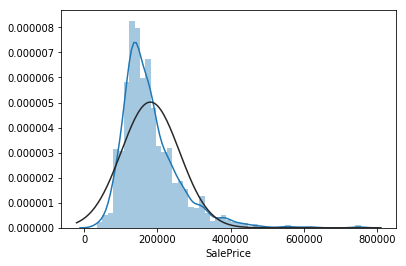

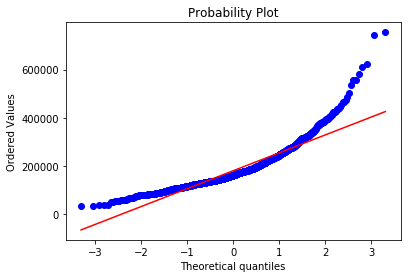

In [33]:
#histogram and normal probability plot
sns.distplot(df.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(df.SalePrice, plot=plt)

If SalePrice was normal distributed, the shape would more closely match the bell shape of the fitted normal distribution. The shape does not fit because on the one hand there is a skew (the peak is clearly left of the peak of the normal distribution) and slighty more difficult to see is the peakedness (kurtosis) since the ascent is more straight than curved. A somewhat easier way to check whether the data is normal distributed is to use a probability plot. If the data is normally distributed, the points would be closer to a straight line. 

The probablility plot also shows if the variance is constant throughout the range, and it is not. We can see the likelihood of the tails exceeds the fitted line. We can run a Box-Cox test to see if there is a transformation that is justified to normalize the data by a simple data transformation. The result of the test tells us what transformation function to use:

| Box-Cox | transformation of Y |
| -- | -- |
| -3 | $-Y^{-3}$ |
| -2 | $-Y^{-2}$ |
| -1 | $-1/Y$ |
| -0.5 | $-1/\sqrt Y$ |
| 0 | $log(Y)$ |
| 0.5 | $\sqrt Y$ |
| 1 | $Y$ |
| 2 | $Y^2$ |
| 3 | $Y^3$ |

In [34]:
stats.boxcox(df.SalePrice)[1]

-0.07715156617829241

The Box-Cox test gives us `-0.07`, therefore either $-SalePrice^{-0.07}$ or using $log(SalePrice)$ should bring us closer to a normal distribution. Since the value is close to 0, a log transformation should work fine, but we will show both and compare.

In [35]:
#applying power transformation
dfp = df.copy()
dfp.SalePrice = -dfp.SalePrice ** -0.08

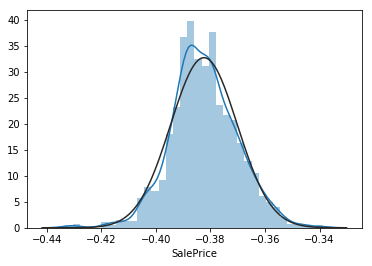

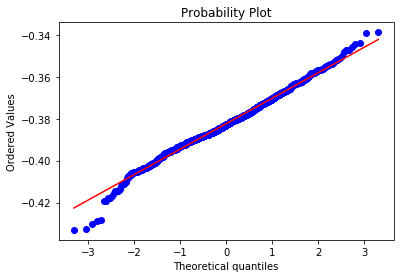

In [36]:
#histogram and normal probability plot
sns.distplot(dfp.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(dfp.SalePrice, plot=plt)

In [37]:
#applying log transformation
dfl = df.copy()
dfl.SalePrice = np.log(dfl.SalePrice)

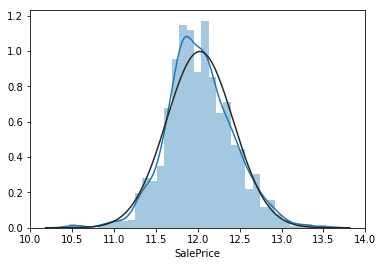

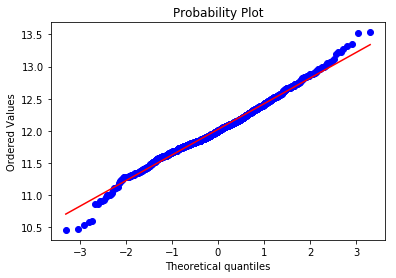

In [38]:
#histogram and normal probability plot
sns.distplot(dfl.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(dfl.SalePrice, plot=plt)

An indeed, we see that both transformations are a lot closer to a normal distribution. In fact, the main deviation may be caused bu outliers (two on the right, five on the left). Basically, we can operate the remainder of our analysis on the converted SalePrice to (hopefully) get more accurate results. The only thing we must not forget is that a predicted sale price is actually the log of the sale price, so we have to invert the log to convert it back to the actual predicted SalePrice.

Now let's do the same thing with GrLiveArea.

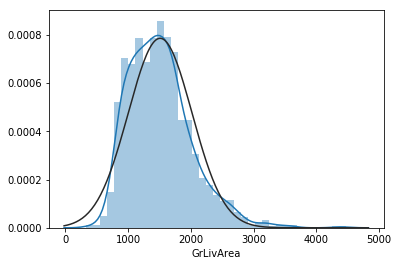

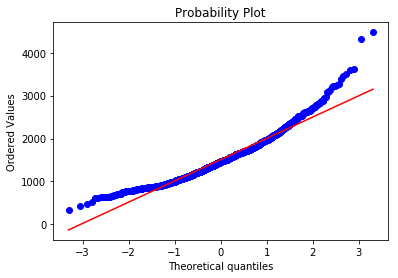

In [39]:
sns.distplot(df.GrLivArea, fit=norm);
fig = plt.figure()
res = stats.probplot(df.GrLivArea, plot=plt)

In [40]:
stats.boxcox(df.GrLivArea)

(array([ 9.78521609,  9.27760704,  9.85876713, ..., 10.32081844,
         9.01853616,  9.26973025]), 0.07039395016529573)

So we can see that we can also use a log transformation to normalize GrLiveArea. When we apply that to both SalePrice and GrLiveArea, let's see how that changes the scatter plot.

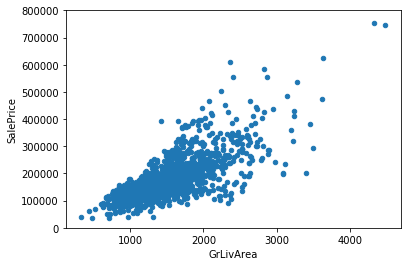

In [41]:
#scatter plot grlivarea/saleprice
data = pd.concat([df.SalePrice, df.GrLivArea], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

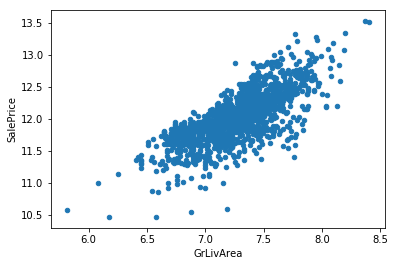

In [42]:
#scatter plot grlivarea/saleprice
dfl.GrLivArea = np.log(df.GrLivArea)
data = pd.concat([dfl.SalePrice, dfl.GrLivArea], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice');

By log transforming SalePrice and GrLiveArea, we see that variance is even across values of the predictor variable (homoscedasticity); for GrLiveArea values of 6.5, 7.0, 7.5, 8.0 we roughly see equal variances in SalePrice. As a result, we see that linear regression is more applicable, there is clearly a stronger linear relationship.

#### Assignment: transform the data for the variable LotArea

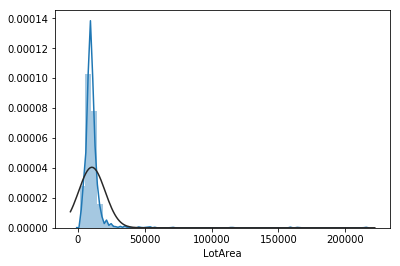

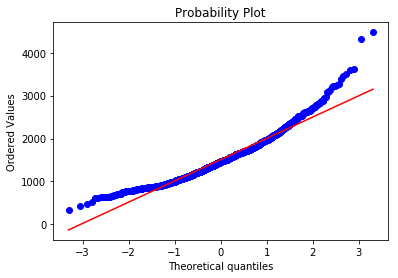

In [43]:
sns.distplot(df.LotArea, fit=norm);
fig = plt.figure()
res = stats.probplot(df.GrLivArea, plot=plt)

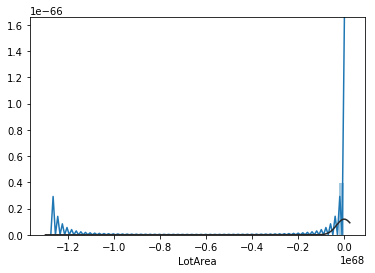

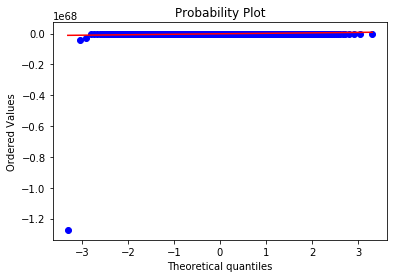

In [57]:
transformer = stats.boxcox(df.LotArea)[1]

#applying power transformation
dfp = df.copy()
dfp.LotArea = -dfp.LotArea ** -transformer

#histogram and normal probability plot
sns.distplot(dfp.LotArea, fit=norm);
fig = plt.figure()
res = stats.probplot(dfp.LotArea, plot=plt)